## 1. Uploading data + prepare (according to EDA notebook)

In [6]:
import os
import numpy as np
import pandas as pd
from IPython.display import display, Markdown
import calendar
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.3f}'.format)

import random
DEFAULT_RANDOM_SEED = 2021
def set_all_seeds(seed=DEFAULT_RANDOM_SEED):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
set_all_seeds(seed=DEFAULT_RANDOM_SEED)

In [15]:
def load_train_test(train_path, test_path):
    train = pd.read_csv(train_path)
    test = pd.read_csv(test_path)

    train['dset'] = 'train'
    test['dset'] = 'test'
    test['dropoff_datetime'] = pd.NaT
    test['trip_duration'] = pd.NA

    df = pd.concat([train, test], ignore_index=True)
    df['dset'] = pd.Categorical(df['dset'], categories=['train', 'test'])
    return df


# Adding geospatial feature --------------------------------------------------------------------------
def add_geospatial_features(df):
    import numpy as np

    JFK = (-73.778889, 40.639722)
    LGA = (-73.872611, 40.77725)

    def bearing(p1, p2):
        p1 = np.asarray(p1)
        p2 = np.asarray(p2)

        if p1.shape != p2.shape or p1.ndim != 2 or p1.shape[1] != 2:
            raise ValueError("p1 and p2 must both be (N, 2) arrays with columns [lon, lat].")

        lon1, lat1 = p1[:, 0], p1[:, 1]
        lon2, lat2 = p2[:, 0], p2[:, 1]

        # Convert to radians
        lon1 = np.deg2rad(lon1); lat1 = np.deg2rad(lat1)
        lon2 = np.deg2rad(lon2); lat2 = np.deg2rad(lat2)

        dlon = lon2 - lon1

        x = np.sin(dlon) * np.cos(lat2)
        y = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(dlon)

        ang = np.arctan2(x, y)                 # radians, [-pi, pi]
        brg = (np.rad2deg(ang) + 360.0) % 360.0  # degrees, [0, 360)

        # Identical points → undefined bearing
        same = (np.isclose(lon1, lon2) & np.isclose(lat1, lat2))
        brg = brg.astype(float)
        brg[same] = np.nan

        return brg

    def dist_haversine(pick, drop):
        R = 6371000  # Earth radius in meters

        pick = np.asarray(pick)
        drop = np.asarray(drop)

        lon1, lat1 = np.deg2rad(pick[:, 0]), np.deg2rad(pick[:, 1])
        lon2, lat2 = np.deg2rad(drop[:, 0]), np.deg2rad(drop[:, 1])

        dlon = lon2 - lon1
        dlat = lat2 - lat1

        a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
        c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

        return R * c

    pick = df[['pickup_longitude', 'pickup_latitude']].to_numpy()
    drop = df[['dropoff_longitude', 'dropoff_latitude']].to_numpy()

    df['bearing'] = bearing(pick, drop)
    df['dist'] = dist_haversine(pick, drop)
    df['jfk_dist_pick'] = dist_haversine(pick, np.tile(JFK, (len(pick), 1)))
    df['jfk_dist_drop'] = dist_haversine(drop, np.tile(JFK, (len(drop), 1)))
    df['lg_dist_pick']  = dist_haversine(pick, np.tile(LGA, (len(pick), 1)))
    df['lg_dist_drop']  = dist_haversine(drop, np.tile(LGA, (len(drop), 1)))
    return df


# Adding temporal features -----------------------------------------------------------------------
def add_temporal_features(df):
    df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
    df['dropoff_datetime'] = pd.to_datetime(df['dropoff_datetime'], errors='coerce')
    df['date'] = df['pickup_datetime'].dt.normalize()
    df['month'] = df['pickup_datetime'].dt.month.astype('Int64')
    df['hour'] = df['pickup_datetime'].dt.hour.astype('Int64')
    df['wday'] = df['pickup_datetime'].dt.dayofweek.map(lambda d: calendar.day_abbr[d])
    df['wday'] = pd.Categorical(df['wday'], categories=["Sun", "Sat", "Mon", "Tue", "Wed", "Thu", "Fri"], ordered=True).codes

    work_days = ["Mon", "Tue", "Wed", "Thu", "Fri"]
    df['work'] = ((df['hour'].between(8, 18)) & (df['wday'].isin(range(2, 7)))).astype(int)

    # Blizzard flag
    start = pd.to_datetime("2016-01-22")
    end = pd.to_datetime("2016-01-29")
    df['blizzard'] = ((df['date'] >= start) & (df['date'] <= end)).astype(int)
    return df


# Load "weather" external data ------------------------------------------------------------------
def load_weather_data(path):
    weather = pd.read_csv(path)
    weather['date'] = pd.to_datetime(weather['date'], dayfirst=True, errors='coerce').dt.normalize()
    weather['rain'] = pd.to_numeric(weather['precipitation'].replace('T', '0.01'), errors='coerce')
    weather['s_fall'] = pd.to_numeric(weather['snow fall'].replace('T', '0.01'), errors='coerce')
    weather['s_depth'] = pd.to_numeric(weather['snow depth'].replace('T', '0.01'), errors='coerce')
    weather['all_precip'] = weather['s_fall'] + weather['rain']
    weather['has_snow'] = (weather['s_fall'] > 0) | (weather['s_depth'] > 0)
    weather['has_rain'] = weather['rain'] > 0
    weather['max_temp'] = weather['maximum temperature']
    weather['min_temp'] = weather['minimum temperature']
    return weather

def merge_weather(df, weather):
    cols = ["date", "rain", "s_fall", "all_precip", "has_snow", "has_rain", "s_depth", "max_temp", "min_temp"]
    return df.merge(weather[cols], on="date", how="left")


# Load & merge "fastest_routes" external dataset -----------------------------------------------
def load_fastest_routes(paths):
    dfs = [pd.read_csv(p) for p in paths]
    fr = pd.concat(dfs, ignore_index=True)
    fr = fr[[
        'id', 'total_distance', 'total_travel_time', 'number_of_steps',
        'step_direction', 'step_maneuvers'
    ]].copy()

    fr['fastest_speed'] = fr['total_distance'] / fr['total_travel_time'] * 3.6
    fr['step_direction'] = fr['step_direction'].fillna('').astype(str)
    fr['step_maneuvers'] = fr['step_maneuvers'].fillna('').astype(str)
    fr['left_turns'] = fr['step_direction'].str.count('left')
    fr['right_turns'] = fr['step_direction'].str.count('right')
    fr['turns'] = fr['step_maneuvers'].str.count('turn')
    return fr.drop(columns=['step_direction', 'step_maneuvers'])


def merge_fastest_routes(df, fr):
    df = df.drop(columns=['total_travel_time', 'total_distance'], errors='ignore')
    return df.merge(fr, on='id', how='left')


# Add categorical and proximity flags ----------------------------------------------------------
def finalize_features(df):
    df['store_and_fwd_flag'] = pd.factorize(df['store_and_fwd_flag'])[0]
    df['vendor_id'] = df['vendor_id'].astype('Int64')
    df['jfk_trip'] = ((df['jfk_dist_pick'] < 2000) | (df['jfk_dist_drop'] < 2000)).astype(int)
    df['lg_trip'] = ((df['lg_dist_pick'] < 2000) | (df['lg_dist_drop'] < 2000)).astype(int)

    return df

In [16]:
df = load_train_test('data/train.csv', 'data/test.csv')

df = add_geospatial_features(df)    # Geo features 
df = add_temporal_features(df)      # Custom features

# Weather external - EXTERNAL DATA
weather = load_weather_data('data/weather_data_nyc_centralpark_2016.xls')
df = merge_weather(df, weather)

# Fastest_routes - EXTERNAL DATA
fr = load_fastest_routes([
    'data/fastest_routes_train_part_1.csv',
    'data/fastest_routes_train_part_2.csv'
])
df = merge_fastest_routes(df, fr)

# Polishing features 
df = finalize_features(df)

df.head(5)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,dset,bearing,dist,jfk_dist_pick,jfk_dist_drop,lg_dist_pick,lg_dist_drop,date,month,hour,wday,work,blizzard,rain,s_fall,all_precip,has_snow,has_rain,s_depth,max_temp,min_temp,total_distance,total_travel_time,number_of_steps,fastest_speed,left_turns,right_turns,turns,jfk_trip,lg_trip
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982,40.768,-73.965,40.766,0,455,train,99.970,1498.521,22290.053,21001.874,9282.498,7856.447,2016-03-14,3,17,2,1,0,0.290,0.000,0.290,False,True,0.000,51,40,2009.100,164.900,5.000,43.861,1.000,1.000,1.000,0,0
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980,40.739,-73.999,40.731,0,663,train,242.846,1805.507,20236.314,21197.232,10047.523,11852.300,2016-06-12,6,0,0,0,0,0.000,0.000,0.000,False,False,0.000,83,62,2513.200,332.000,6.000,27.252,2.000,2.000,2.000,0,0
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979,40.764,-74.005,40.710,0,2124,train,200.320,6385.098,21804.112,20637.271,9082.822,13445.949,2016-01-19,1,11,3,1,0,0.000,0.000,0.000,True,False,0.010,28,16,11060.800,767.600,16.000,51.875,5.000,7.000,9.000,0,0
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010,40.720,-74.012,40.707,0,429,train,187.262,1485.498,21437.495,21044.602,13213.305,14140.080,2016-04-06,4,19,4,0,0,0.000,0.000,0.000,False,False,0.000,48,30,1779.400,235.800,4.000,27.166,2.000,1.000,1.000,0,0
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973,40.793,-73.973,40.783,0,435,train,179.474,1188.588,23644.565,22794.603,8640.673,8466.550,2016-03-26,3,13,1,0,0,0.000,0.000,0.000,False,False,0.000,55,38,1614.900,140.100,5.000,41.496,2.000,2.000,3.000,0,0


In [17]:
train_cols = [
    "total_travel_time", "total_distance", "hour", "dist", "vendor_id", "jfk_trip",
    "lg_trip", "wday", "month", "pickup_longitude", "pickup_latitude", "bearing", "lg_dist_drop"
]
id_col = ["id"]
aux_cols = ["dset"]
clean_cols = ["jfk_dist_drop", "jfk_dist_pick"]
target = ["trip_duration"]

test_id = df.loc[df['dset'] == 'test', id_col].copy()
cols = train_cols + target + aux_cols + clean_cols

df_train = df[cols].copy()
df_train.head(5)

,total_travel_time,total_distance,hour,dist,vendor_id,jfk_trip,lg_trip,wday,month,pickup_longitude,pickup_latitude,bearing,lg_dist_drop,trip_duration,dset,jfk_dist_drop,jfk_dist_pick
0,164.900,2009.100,17,1498.521,2,0,0,2,3,-73.982,40.768,99.970,7856.447,455,train,21001.874,22290.053
1,332.000,2513.200,0,1805.507,1,0,0,0,6,-73.980,40.739,242.846,11852.300,663,train,21197.232,20236.314
2,767.600,11060.800,11,6385.098,2,0,0,3,1,-73.979,40.764,200.320,13445.949,2124,train,20637.271,21804.112
3,235.800,1779.400,19,1485.498,2,0,0,4,4,-74.010,40.720,187.262,14140.080,429,train,21044.602,21437.495
4,140.100,1614.900,13,1188.588,2,0,0,1,3,-73.973,40.793,179.474,8466.550,435,train,22794.603,23644.565


## 2. Model training

In [ ]:
from sklearn.model_selection import train_test_split

# Split train/test
train = df_train.loc[df_train['dset'] == 'train'].drop(columns=aux_cols)
test = df_train.loc[df_train['dset'] == 'test'].drop(columns=aux_cols + clean_cols + target)

# Transform target into "log"
train['trip_duration'] = np.log1p(train['trip_duration'].astype(float))

train = train[train['trip_duration'] < 24*3600]

# Dropping columns
cols_2_drop = ['total_travel_time', 'total_distance']
test = train.drop(columns=['trip_duration', 'jfk_dist_drop', 'jfk_dist_pick'], errors='ignore')


train_part, valid = train_test_split(train, train_size=0.8, random_state=4321)
valid = valid.drop(columns=clean_cols)

# Removing anomaly trips
train_part = train_part[
    (train_part['jfk_dist_pick'] < 300000) & (train_part['jfk_dist_drop'] < 300000) \
].drop(columns=clean_cols)

# dropping columns
foo = train_part.drop(columns=["trip_duration"]).copy()
bar = valid.drop(columns=["trip_duration"]).copy()

In [61]:
from sklearn.metrics import mean_squared_error

def clean_from_NaNs(train):

    train_cleaned = train.dropna()
    train_part_cleaned, valid_cleaned = train_test_split(train_cleaned, train_size=0.8, random_state=4321)
    
    valid_cleaned = valid_cleaned.drop(columns=clean_cols)
    train_part_cleaned = train_part_cleaned[
        (train_part_cleaned['jfk_dist_pick'] < 300000) & (train_part_cleaned['jfk_dist_drop'] < 300000) \
    ].drop(columns=clean_cols)

    foo_cleaned = train_part_cleaned.drop(columns=["trip_duration"]).copy()
    bar_cleaned = valid_cleaned.drop(columns=["trip_duration"]).copy()

    return train_part_cleaned, valid_cleaned, foo_cleaned, bar_cleaned

def evaluate_model(model, X_train, y_train, X_valid, y_valid, name="Model"):
    model.fit(X_train, y_train)
    preds = model.predict(X_valid)
    rmse = np.sqrt(mean_squared_error(y_valid, preds))
    print(f"{name} RMSE: {rmse:.4f}")
    return model, preds, rmse

In [48]:
display(foo.head(5)) # TRAIN
bar.head(5) # VALID

,total_travel_time,total_distance,hour,dist,vendor_id,jfk_trip,lg_trip,wday,month,pickup_longitude,pickup_latitude,bearing,lg_dist_drop
125666,510.900,4697.500,1,3314.189,1,0,0,6,1,-73.997,40.737,16.535,9601.196
1346790,480.300,5060.800,6,4113.155,1,0,0,3,4,-73.991,40.756,43.838,7179.271
538386,269.200,1941.900,17,1279.390,2,0,0,0,2,-73.988,40.742,230.468,11694.070
1338774,133.200,1302.600,7,1004.518,1,0,0,5,6,-73.966,40.762,226.774,8933.644
632642,143.700,1871.300,11,1293.230,1,0,0,0,2,-73.951,40.805,244.994,8204.686


,total_travel_time,total_distance,hour,dist,vendor_id,jfk_trip,lg_trip,wday,month,pickup_longitude,pickup_latitude,bearing,lg_dist_drop
551485,78.900,630.300,22,486.114,1,0,0,4,6,-73.984,40.758,261.421,10097.742
820590,1045.100,20342.000,22,13041.190,2,1,0,5,4,-73.777,40.645,6.348,9670.389
767551,90.700,1058.400,12,852.809,1,0,0,4,2,-73.961,40.772,135.579,6968.889
396396,313.700,2432.300,11,1901.353,2,0,0,6,4,-74.010,40.721,172.889,13975.864
1283524,1739.700,31569.100,18,21908.043,2,1,0,6,1,-73.789,40.648,317.435,7936.205


### Linear Regression - `rmse 0.502`

In [82]:
from sklearn.linear_model import LinearRegression

train_part_cleaned, valid_cleaned, foo_cleaned, bar_cleaned = clean_from_NaNs(train)
lr = LinearRegression()

lr_model, lr_preds, rmse = evaluate_model(
    lr,
    foo_cleaned, train_part_cleaned['trip_duration'],
    bar_cleaned, valid_cleaned['trip_duration'],
    name="Linear Regression"
)

Linear Regression RMSE: 0.5022


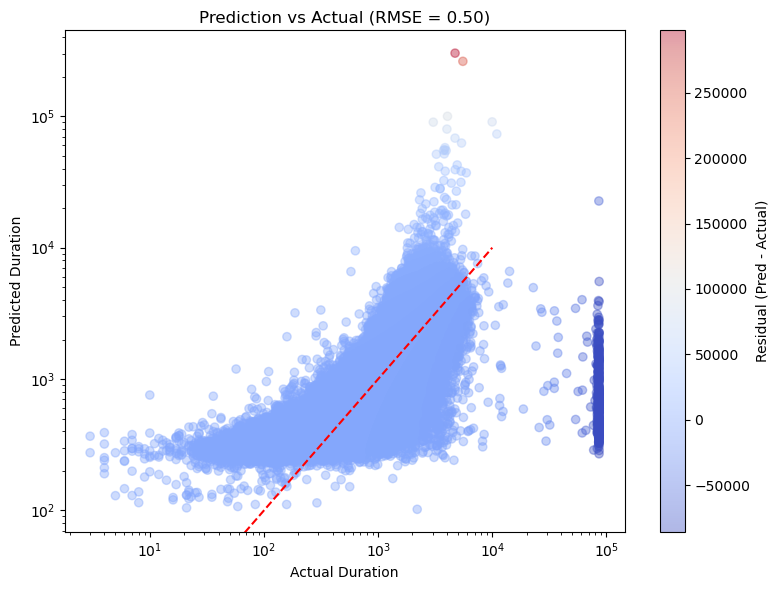

In [83]:
actual = np.expm1(valid_cleaned["trip_duration"])
preds = np.expm1(lr_preds)
residuals = preds - actual

plt.figure(figsize=(8, 6))
plt.scatter(actual, preds, c=residuals, cmap='coolwarm', alpha=0.4)
plt.plot([0, 10000], [0, 10000], color='red', linestyle='--')
plt.colorbar(label="Residual (Pred - Actual)")
plt.xlabel("Actual Duration")
plt.ylabel("Predicted Duration")
plt.title("Prediction vs Actual with Residuals")
plt.xscale('log')
plt.yscale('log')
plt.tight_layout()
plt.title(f"Prediction vs Actual (RMSE = {rmse:.2f})")
plt.show()

### Ridge Regression - `rmse 0.502`

In [74]:
from sklearn.linear_model import Ridge

train_part_cleaned, valid_cleaned, foo_cleaned, bar_cleaned = clean_from_NaNs(train)
ridge = Ridge(alpha=1.0)

ridge_model, ridge_preds, rmse = evaluate_model(
    ridge,
    foo_cleaned, train_part_cleaned['trip_duration'],
    bar_cleaned, valid_cleaned['trip_duration'],
    name="Ridge Regression"
)

Ridge Regression RMSE: 0.5022


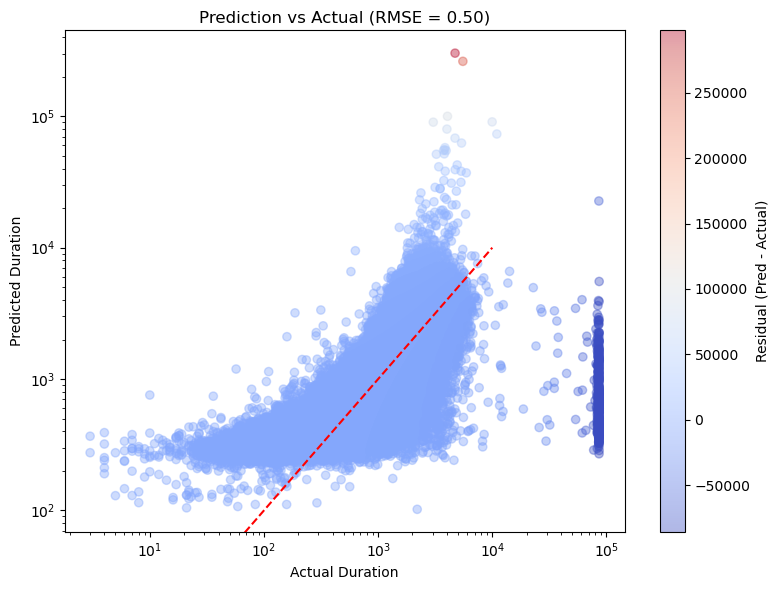

In [75]:
actual = np.expm1(valid_cleaned["trip_duration"])
preds = np.expm1(ridge_preds)
residuals = preds - actual

plt.figure(figsize=(8, 6))
plt.scatter(actual, preds, c=residuals, cmap='coolwarm', alpha=0.4)
plt.plot([0, 10000], [0, 10000], color='red', linestyle='--')
plt.colorbar(label="Residual (Pred - Actual)")
plt.xlabel("Actual Duration")
plt.ylabel("Predicted Duration")
plt.title("Prediction vs Actual with Residuals")
plt.xscale('log')
plt.yscale('log')
plt.tight_layout()
plt.title(f"Prediction vs Actual (RMSE = {rmse:.2f})")
plt.show()

### Lasso (L1 reg) - `rmse 0.514`

In [76]:
from sklearn.linear_model import Lasso

train_part_cleaned, valid_cleaned, foo_cleaned, bar_cleaned = clean_from_NaNs(train)
lasso = Lasso(alpha=0.1)

lasso_model, lasso_preds, rmse = evaluate_model(
    lasso,
    foo_cleaned, train_part_cleaned['trip_duration'],
    bar_cleaned, valid_cleaned['trip_duration'],
    name="Lasso Regression"
)

Lasso Regression RMSE: 0.5137


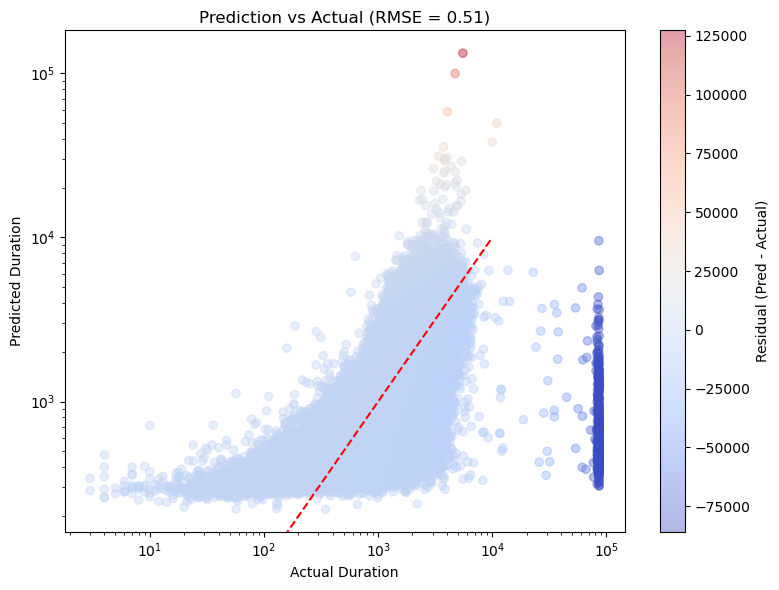

In [77]:
actual = np.expm1(valid_cleaned["trip_duration"])
preds = np.expm1(lasso_preds)
residuals = preds - actual

plt.figure(figsize=(8, 6))
plt.scatter(actual, preds, c=residuals, cmap='coolwarm', alpha=0.4)
plt.plot([0, 10000], [0, 10000], color='red', linestyle='--')
plt.colorbar(label="Residual (Pred - Actual)")
plt.xlabel("Actual Duration")
plt.ylabel("Predicted Duration")
plt.title("Prediction vs Actual with Residuals")
plt.xscale('log')
plt.yscale('log')
plt.tight_layout()
plt.title(f"Prediction vs Actual (RMSE = {rmse:.2f})")
plt.show()

### Elastic (L1 + L2) - `rmse 0.512`

In [78]:
from sklearn.linear_model import ElasticNet

elastic = ElasticNet(alpha=0.1, l1_ratio=0.5)

elastic_model, elastic_preds, rmse = evaluate_model(
    elastic,
    foo_cleaned, train_part_cleaned['trip_duration'],
    bar_cleaned, valid_cleaned['trip_duration'],
    name="ElasticNet"
)

ElasticNet RMSE: 0.5117


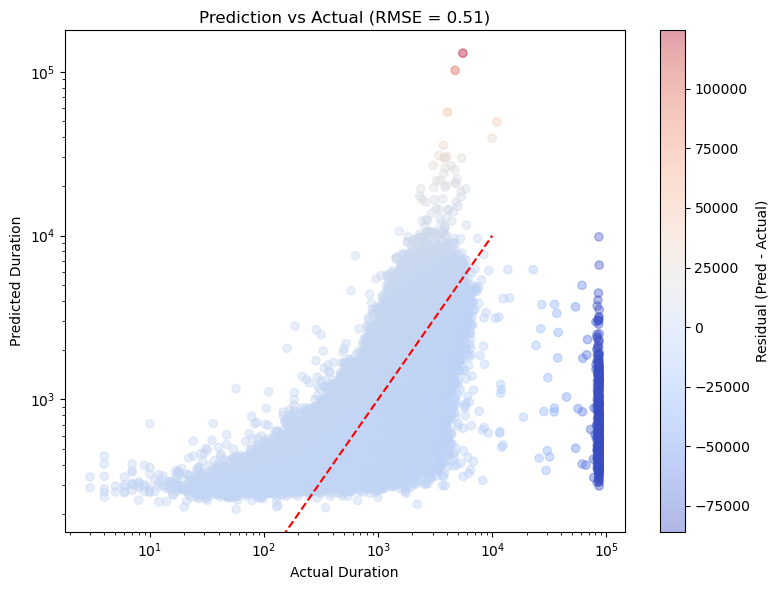

In [79]:
actual = np.expm1(valid_cleaned["trip_duration"])
preds = np.expm1(elastic_preds)
residuals = preds - actual

plt.figure(figsize=(8, 6))
plt.scatter(actual, preds, c=residuals, cmap='coolwarm', alpha=0.4)
plt.plot([0, 10000], [0, 10000], color='red', linestyle='--')
plt.colorbar(label="Residual (Pred - Actual)")
plt.xlabel("Actual Duration")
plt.ylabel("Predicted Duration")
plt.title("Prediction vs Actual with Residuals")
plt.xscale('log')
plt.yscale('log')
plt.tight_layout()
plt.title(f"Prediction vs Actual (RMSE = {rmse:.2f})")
plt.show()

### Polynomial - `rmse 0.443`

In [80]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

train_part_cleaned, valid_cleaned, foo_cleaned, bar_cleaned = clean_from_NaNs(train)
poly_model = make_pipeline(
    PolynomialFeatures(degree=2),
    Ridge(alpha=1.0)
)

poly_model, poly_preds, rmse = evaluate_model(
    poly_model,
    foo_cleaned, train_part_cleaned['trip_duration'],
    bar_cleaned, valid_cleaned['trip_duration'],
    name="Polynomial Ridge Regression"
)

c:\Anaconda\envs\DS_pactice_3-10-18\lib\site-packages\sklearn\linear_model\_ridge.py:213: LinAlgWarning: Ill-conditioned matrix (rcond=1.14947e-23): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Polynomial Ridge Regression RMSE: 0.4428


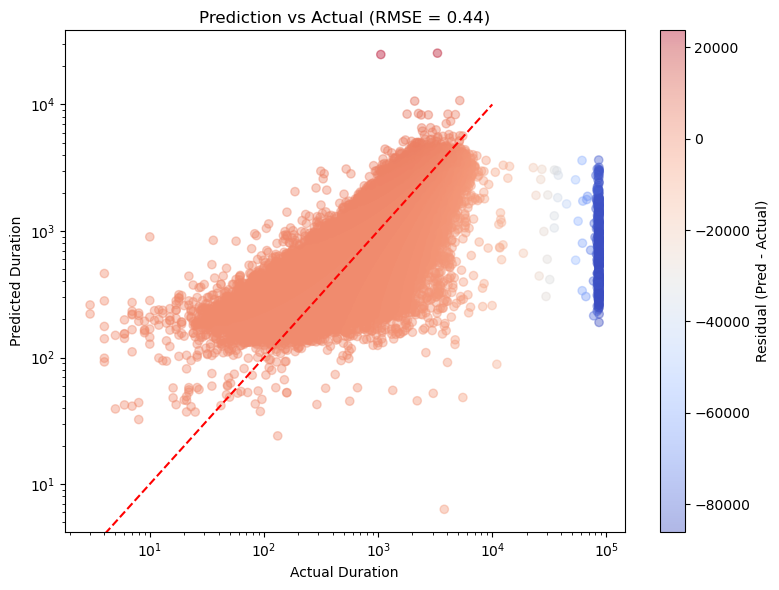

In [81]:
actual = np.expm1(valid_cleaned["trip_duration"])
preds = np.expm1(poly_preds)
residuals = preds - actual

plt.figure(figsize=(8, 6))
plt.scatter(actual, preds, c=residuals, cmap='coolwarm', alpha=0.4)
plt.plot([0, 10000], [0, 10000], color='red', linestyle='--')
plt.colorbar(label="Residual (Pred - Actual)")
plt.xlabel("Actual Duration")
plt.ylabel("Predicted Duration")
plt.title("Prediction vs Actual with Residuals")
plt.xscale('log')
plt.yscale('log')
plt.tight_layout()
plt.title(f"Prediction vs Actual (RMSE = {rmse:.2f})")
plt.show()

### Random Forest - `rmse 0.407`

In [27]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(
    n_estimators=100,
    max_depth=15,
    random_state=42,
    n_jobs=-1
)

rf_model, rf_preds, rmse = evaluate_model(
    rf,
    foo, train_part['trip_duration'],
    bar, valid['trip_duration'],
    name="Random Forest"
)

Random Forest RMSE: 0.4073


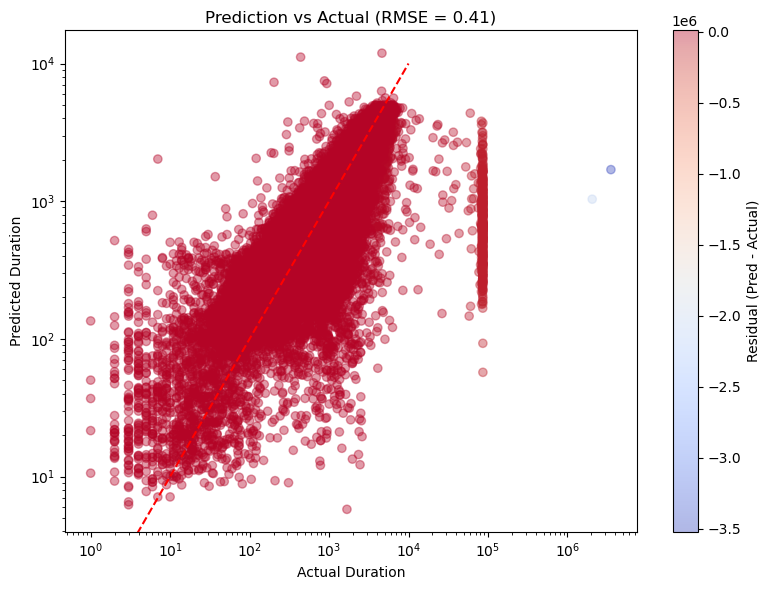

In [29]:
actual = np.expm1(valid["trip_duration"])
preds = np.expm1(rf_preds)
residuals = preds - actual

plt.figure(figsize=(8, 6))
plt.scatter(actual, preds, c=residuals, cmap='coolwarm', alpha=0.4)
plt.plot([0, 10000], [0, 10000], color='red', linestyle='--')
plt.colorbar(label="Residual (Pred - Actual)")
plt.xlabel("Actual Duration")
plt.ylabel("Predicted Duration")
plt.title("Prediction vs Actual with Residuals")
plt.xscale('log')
plt.yscale('log')
plt.tight_layout()
plt.title(f"Prediction vs Actual (RMSE = {rmse:.2f})")
plt.show()

### CatBoost - `rmse = 0.396`

In [31]:
from catboost import CatBoostRegressor

cat_model = CatBoostRegressor(
    iterations=200,
    depth=10,
    learning_rate=0.1,
    loss_function='RMSE',
    verbose=0,
    random_state=42
)

cat_model, cat_preds, rmse = evaluate_model(
    cat_model,
    foo, train_part['trip_duration'],
    bar, valid['trip_duration'],
    name="CatBoost"
)

CatBoost RMSE: 0.3963


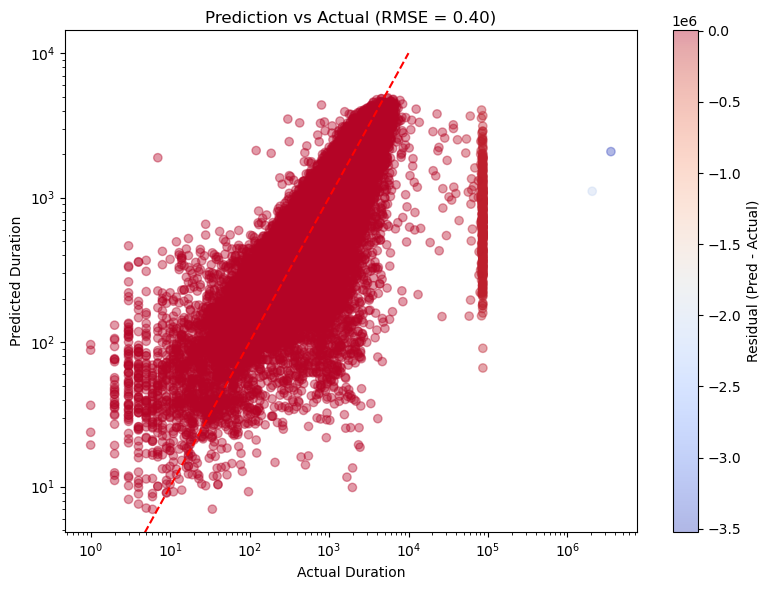

In [32]:
actual = np.expm1(valid["trip_duration"])
preds = np.expm1(cat_preds)
residuals = preds - actual

plt.figure(figsize=(8, 6))
plt.scatter(actual, preds, c=residuals, cmap='coolwarm', alpha=0.4)
plt.plot([0, 10000], [0, 10000], color='red', linestyle='--')
plt.colorbar(label="Residual (Pred - Actual)")
plt.xlabel("Actual Duration")
plt.ylabel("Predicted Duration")
plt.title("Prediction vs Actual with Residuals")
plt.xscale('log')
plt.yscale('log')
plt.tight_layout()
plt.title(f"Prediction vs Actual (RMSE = {rmse:.2f})")
plt.show()

### XGBoost - `rmse = 0.400`

In [112]:
import xgboost as xgb

# matrix creation
dtrain = xgb.DMatrix(foo, label=train_part["trip_duration"])
dvalid = xgb.DMatrix(bar, label=valid["trip_duration"])
dtest = xgb.DMatrix(test)

# hyperparemeters
xgb_params = {
    "colsample_bytree": 0.7,
    "subsample": 0.7,
    "booster": "gbtree",
    "max_depth": 5,
    "eta": 0.3,
    "eval_metric": "rmse",
    "objective": "reg:squarederror",  # reg:linear is deprecated
    "seed": 4321
}

watchlist = [(dtrain, "train"), (dvalid, "valid")]


# training
gb_dt = xgb.train(
    params=xgb_params,
    dtrain=dtrain,
    num_boost_round=350,
    evals=watchlist,
    early_stopping_rounds=20,
    verbose_eval=10
)

# cross validation
xgb_cv = xgb.cv(
    params=xgb_params,
    dtrain=dvalid,
    num_boost_round=15,
    early_stopping_rounds=10,
    nfold=5,
    verbose_eval=False
)


[0]	train-rmse:0.65541	valid-rmse:0.65647
[10]	train-rmse:0.43261	valid-rmse:0.43617
[20]	train-rmse:0.41907	valid-rmse:0.42341
[30]	train-rmse:0.41177	valid-rmse:0.41690
[40]	train-rmse:0.40728	valid-rmse:0.41314
[50]	train-rmse:0.40373	valid-rmse:0.40994
[60]	train-rmse:0.40117	valid-rmse:0.40793
[70]	train-rmse:0.39930	valid-rmse:0.40656
[80]	train-rmse:0.39786	valid-rmse:0.40548
[90]	train-rmse:0.39631	valid-rmse:0.40443
[100]	train-rmse:0.39504	valid-rmse:0.40364
[110]	train-rmse:0.39407	valid-rmse:0.40326
[120]	train-rmse:0.39318	valid-rmse:0.40296
[130]	train-rmse:0.39223	valid-rmse:0.40247
[140]	train-rmse:0.39129	valid-rmse:0.40230
[150]	train-rmse:0.39042	valid-rmse:0.40194
[160]	train-rmse:0.38959	valid-rmse:0.40163
[170]	train-rmse:0.38886	valid-rmse:0.40133
[180]	train-rmse:0.38793	valid-rmse:0.40108
[190]	train-rmse:0.38731	valid-rmse:0.40086
[200]	train-rmse:0.38666	valid-rmse:0.40086
[210]	train-rmse:0.38581	valid-rmse:0.40067
[220]	train-rmse:0.38512	valid-rmse:0.40083

RMSE: 0.3996


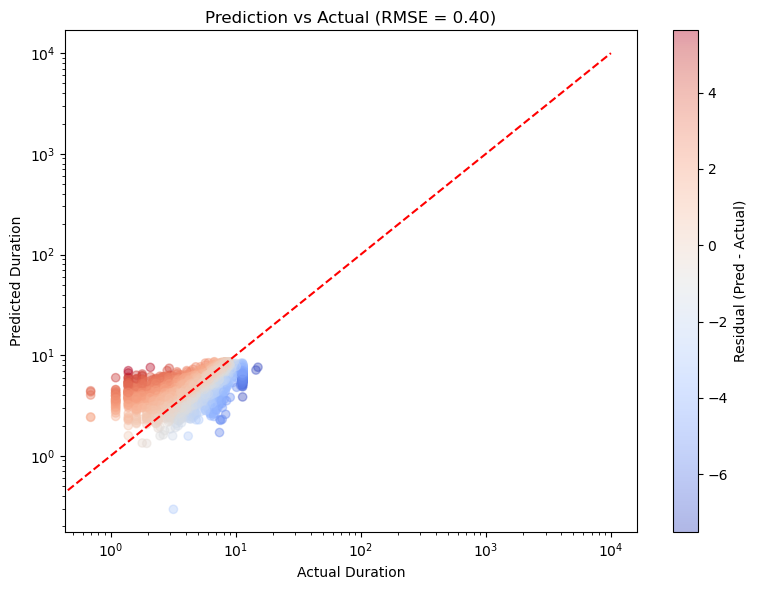

In [113]:
from sklearn.metrics import mean_squared_error

actual = valid["trip_duration"]
pred = gb_dt.predict(dvalid)
residual = pred - actual
rmse = np.sqrt(mean_squared_error(valid["trip_duration"], gb_dt.predict(dvalid)))
print(f"RMSE: {rmse:.4f}")

plt.figure(figsize=(8, 6))
plt.scatter(actual, pred, c=residual, cmap='coolwarm', alpha=0.4)
plt.plot([0, 10000], [0, 10000], color='red', linestyle='--')
plt.colorbar(label="Residual (Pred - Actual)")
plt.xlabel("Actual Duration")
plt.ylabel("Predicted Duration")
plt.title("Prediction vs Actual with Residuals")
plt.xscale('log')
plt.yscale('log')
plt.tight_layout()
plt.title(f"Prediction vs Actual (RMSE = {rmse:.2f})")
plt.show()

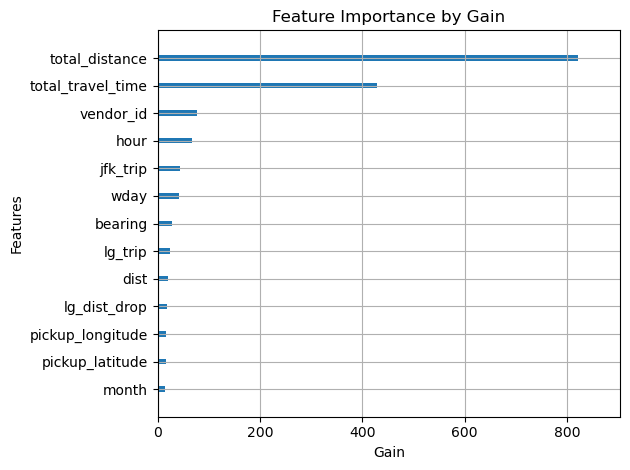

In [22]:
importance = xgb.plot_importance(gb_dt, importance_type='gain', show_values=False)
plt.title("Feature Importance by Gain")
plt.xlabel("Gain")
plt.ylabel("Features")
plt.tight_layout()
plt.show()

In [110]:
import xgboost as xgb

# matrix creation
dtrain = xgb.DMatrix(foo, label=np.log1p(train_part["trip_duration"]))
dvalid = xgb.DMatrix(bar, label=np.log1p(valid["trip_duration"]))
dtest = xgb.DMatrix(test)

# hyperparemeters
xgb_params = {
    "colsample_bytree": 0.7,
    "subsample": 0.7,
    "booster": "gbtree",
    "max_depth": 5,
    "eta": 0.3,
    "eval_metric": "rmse",
    "objective": "reg:squarederror",  # reg:linear is deprecated
    "seed": 4321
}

watchlist = [(dtrain, "train"), (dvalid, "valid")]


# training
gb_dt = xgb.train(
    params=xgb_params,
    dtrain=dtrain,
    num_boost_round=350,
    evals=watchlist,
    early_stopping_rounds=20,
    verbose_eval=10
)

# cross validation
xgb_cv = xgb.cv(
    params=xgb_params,
    dtrain=dvalid,
    num_boost_round=15,
    early_stopping_rounds=10,
    nfold=5,
    verbose_eval=False
)


[0]	train-rmse:0.09378	valid-rmse:0.09341
[10]	train-rmse:0.06291	valid-rmse:0.06291
[20]	train-rmse:0.06077	valid-rmse:0.06094
[30]	train-rmse:0.05966	valid-rmse:0.05999
[40]	train-rmse:0.05914	valid-rmse:0.05960
[50]	train-rmse:0.05864	valid-rmse:0.05926
[60]	train-rmse:0.05826	valid-rmse:0.05902
[70]	train-rmse:0.05793	valid-rmse:0.05882
[80]	train-rmse:0.05763	valid-rmse:0.05865
[90]	train-rmse:0.05735	valid-rmse:0.05855
[100]	train-rmse:0.05712	valid-rmse:0.05850
[110]	train-rmse:0.05686	valid-rmse:0.05842
[120]	train-rmse:0.05664	valid-rmse:0.05837
[130]	train-rmse:0.05641	valid-rmse:0.05836
[140]	train-rmse:0.05618	valid-rmse:0.05832
[150]	train-rmse:0.05600	valid-rmse:0.05829
[160]	train-rmse:0.05582	valid-rmse:0.05827
[170]	train-rmse:0.05567	valid-rmse:0.05827
[180]	train-rmse:0.05550	valid-rmse:0.05828
[190]	train-rmse:0.05535	valid-rmse:0.05826
[200]	train-rmse:0.05521	valid-rmse:0.05827
[210]	train-rmse:0.05507	valid-rmse:0.05828
[211]	train-rmse:0.05505	valid-rmse:0.05828

RMSE: 0.4035


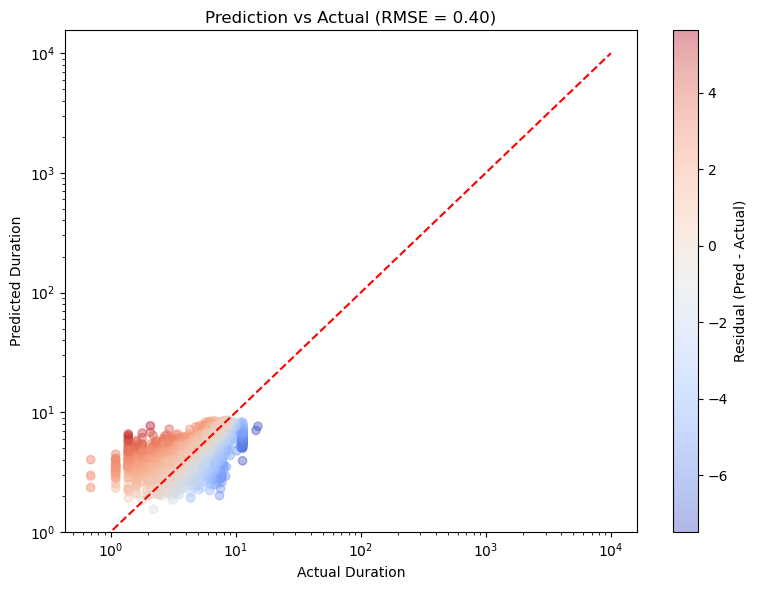

In [111]:
from sklearn.metrics import mean_squared_error

actual = valid["trip_duration"]
pred = np.expm1(gb_dt.predict(dvalid))
residual = pred - actual
rmse = np.sqrt(mean_squared_error(actual, pred))
print(f"RMSE: {rmse:.4f}")

plt.figure(figsize=(8, 6))
plt.scatter(actual, pred, c=residual, cmap='coolwarm', alpha=0.4)
plt.plot([0, 10000], [0, 10000], color='red', linestyle='--')
plt.colorbar(label="Residual (Pred - Actual)")
plt.xlabel("Actual Duration")
plt.ylabel("Predicted Duration")
plt.title("Prediction vs Actual with Residuals")
plt.xscale('log')
plt.yscale('log')
plt.tight_layout()
plt.title(f"Prediction vs Actual (RMSE = {rmse:.2f})")
plt.show()